# **Installation of the RDKit**

In [1]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


/opt/conda/lib/python3.10/site-packages/torch/cuda/__init__.py:83: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


### RDKit test

A sense check to ensure RDKit is correctly working. You should see an image of caffiene as the output of the following cell.

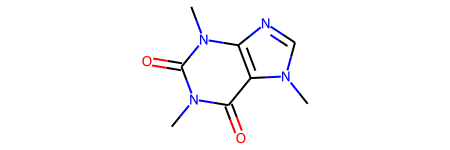

In [2]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw, AllChem
IPythonConsole.ipython_useSVG=True 
Chem.MolFromSmiles("CN1C=NC2=C1C(=O)N(C(=O)N2C)C")




---


# Method configuration

First it configures the output of graphs to display in the notebook then it sets up teh params object, which can control all of the experiments that run in the ntoebook. To examine different possibilities change the params object and rerun the notebook.

In [3]:
#Center output
#from IPython.display import display, HTML
CSS = """
.output {
    align-items: center;
}
"""
#HTML('<style>{}</style>'.format(CSS))

# Enables large output display
#from IPython.core.display import display, HTML
#display(HTML("<style>div.output_scroll { height: 44em; }</style>"))

#from google.colab import data_table
#data_table.enable_dataframe_formatter()

from IPython.display import display, HTML

def show(obj):
  display(HTML(obj.to_html(escape=False)))


In [4]:
from IPython.display import display
import FLuID as fluid
import plotly.express as px
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

###
# Consortium size
k = 8

params = {
    
    # experiment details
    'details' : 3,                  # level of detail of the experiment (low=1,medium=2,high=3,full=4)
    
    # datafiles
'training_data_file' : 'hERG_lhasa_training',
    'test_data_file' : 'hERG_lhasa_test',
'transfer_data_file' : 'FLuID_full',
  'fluid_label_file' : 'FLuID_labels',
    
    # data sampling
   'validation_ratio': 0.2,        # ratio validation/training
     'transfer_size' : 50000 ,      # sample for the transfer data (-1 = all)
         'test_size' : -1,          # sample for the test data (-1 = all)
     'training_size' : -1,          # sample for the training data (-1 = all)

    # number of teacher/clusters (kMean)
                 'k' : k,           # number of clusters (kMean)
     'smooth_factor' : 0.05,        # level of post-clustering mixing to avoid fully biased teachers
    
    # teachers
 'teacher_algorithm' : 'rf',        # algorithm used to build the teacher models
    
    # students
 'federated_student' : 'F' + str(k),
      'student_size' : 10000,                                              # size of the student (number of labelled Cronos data used)
      'student_sizes' : [100,250,500, 1000,2500,5000,10000,25000,50000],   # sizes of the student ti study the impact of the size
 'student_algorithm' : 'rf',                                               # default algorithm used to build the student models
      'student_mode' : 'balanced',                                         # default mode used to select the student data 
    
    # random seed for reproductibility
      'random_state' : 42,

    # t-SNE settings
         'tsne_size' : 500,
   'tsne_iterations' : 1000,
    
    # replication level
    'replicate_count' : 3,
    
    # fonts
       'figure_font' : dict(family="Arial",size=14,color="black"),
 'small_figure_font' : dict(family="Arial",size=10,color="black"),

    # colors
'figure_color_scale' : [(0,"red"),(0.2,"orange"), (0.3,'yellow'),(1,'green')],
        'bar_colors' : px.colors.qualitative.Prism,
         'green_map' : plt.get_cmap('Greens')
}

In [5]:
import importlib
importlib.reload(fluid)

<module 'FLuID' from '/home/mit/work/submission/FLuID_POC/FLuID.py'>



---
# **From Private Data to Public Knowledge**
---

## Abstract

In this note book, we demonstrate a data driven federated learning using the Teacher-Student approach to transfer knowledge from confidential data into public knowledge whilst preserving the privacy of the source data.

We use the hERG endpoint to validate the concept in the context of a classification task. 

- The sources of knowledge to federate are simulated by clustering a set of curated ChEMBL data into subspaces representing different chemical domains

- Using a k-mean algortihm and FCFP2 as the domain representation, we split the ChEMBL data into k different clusters, each cluster representing a virtual member of the federation.

- Next, we train k teachers models from the associated cluster data. Thiese teacher models represent private models that can be trained within the private space of each federation member.

- We then annotate a large collection (100k) of unlabelled public data  using these teachers (one label/teachers) leading to a matrix of k labels for each structure. The collection of unlabbeled data is call the transfer data.

- We consolidate the k labels into a single federated label using an a weighted average scheme over the classe probabilityies across the k labels. This step results in a new dataset of 100k structures annotated with a federated label; this label can be seen as a surrogate for an experimental label.

- Next we build a student model using the annotated transfer data as a training set

- In order to validate the approach, we compare the performance of the teachers models with the student model. More specififically we will use the Mathew Correlation Coefficient (MCC) as the accuracy metric and compare the average teacher performance woth the student performance when validated against an external test set.

- If the student is performing better than the average teacher performance we consider the concept as validated

The idea is to demonstrate that although the teachers capture source knowledge about different chemical spaces (cluster separation), the student will be able to federate the knowledge across the teachers and outperform individual teachers when validated against an external  dataset 

We will also look at different aspects of this experiment like the individual contribution of each teacher, the impact of the number of teachers, the size of the transfer data set, etc.

## Data preparation

We will uses three datasets:

- Public ChEMBL hERG data as a source of knowledge for the teachers
- Preissner as benchmark data from the [Preissner et al. paper](https://pubs.acs.org/doi/10.1021/acs.jcim.8b00150)
- FLuID as transfer data

We are going to use ChEMBL hERG data as the source for the teachers' data. The ChEMBL data will be clustered to simulate different sources (teachers) covering distinct chemical spaces. Dupplicates are removed.

As we load the datasets we create an activity table and compute the fingerprints

We use the Preissner dataset as an external test set to benchmark our teachers and students. Preissner compounds overlapping with ChEMBL data are removed. We also make sure there are no internal dupplicates (including stereo-isomers and tautomers).

FLuID is our dataset prepared from 100 millions Puch Chem structures sampled down to 1M and further tiled down to 350k structures that evenly cover the PuchChem space and hence represents a large homogeneous chemical space.

In [6]:
####
# Load and prepare the data
# if force_sdf True we force reloading from the SDF files
# as the transfer data is so large it arrives as a zip and will be unzipped into the sdf before it is used
force_sdf = False 
training_full = fluid.load_training_data(params, force_sdf)
test_full = fluid.load_test_data(training_full, params, force_sdf)
transfer_full = fluid.load_transfer_data(params, force_sdf)

From pickle training data size = 7772
From pickle test data size = 4383
From pickle transfer data size = 347717


Sampling the data according to the experiment configuration:

In [7]:
####
# Sample the desired size of data according to the experiment parameters
training_data, test_data, transfer_data, validation_data = fluid.sample_data(training_full, test_full, transfer_full, params)

Validation data size = 1554
Training data size = 6218
Test data size = 4383
Transfer data size = 50000


## Creating Teachers
### Teacher source space

We use the ChEMBL training dataset as the source space for the teachers. 
Here we see the global activity distribution of the source data.

Use the ChEMBL data as the source data for the experiment. This data is going to be split in training and validation sets. The training set will be the base of the simulation (split in 'k' individual member data sets).

In [8]:
%matplotlib inline
import plotly.io as pio
pio.renderers.default = "iframe"

### Dataset Examinations

Here we simply observe the ratio of activity between the datasets. The Source Space is all of the data from ChEMBL. THis is split into the training space and validation space, to be used for training and validation. You can see that they are both almost balanced. The final space is the test space consisting of the collected dataset from Preissner et al, which you can see is rather unbalanced with many more inactive compounds versus the number of active compounds.

In [9]:
####
# Use the training data as teacher source space
# and plot the class distribution in this space
teacher_space = training_data
fluid.display_distribution(teacher_space,'ACTIVITY',"Source space class distribution")

### Training space
The training data will be used as the teacher domain space. This space will be divided in 'k' individal member spaces.

In [10]:
fluid.display_distribution(training_data,'ACTIVITY',"ChEMBL training space")

### Validation space
The validation data will be used validate the models within the original source space

In [11]:
fluid.display_distribution(validation_data,'ACTIVITY',"ChEMBL validation space")

### Test space
The Preissner data will be used as the external validation space. It is independent from the original ChEMBL domain.

In [12]:
fluid.display_distribution(test_data,'ACTIVITY',"Preissner test space")

### Create teacher data

Next we create k teachers using k clusters from the ChEMBL training data using kMean clustering.
We use the Scikit Learn kMean implementation. *Unfortunately the default and only distance metric in this version is Euclidian but ideally we would like to work with the Tanimoto similarity.*

As we can see in the bar plot below, the k clusters are distributed into different sizes and different bias between active and inactive compounds. This gives us a good variety of virtual contributors to the federated model and fits with a real world situation.

We extract the teacher data from the ChEMBL clusters; each cluster provides the data for one individual teacher. We have added one special teacher T0 (not used in the federation process) that is trained on all the ChEMBL data. T0 will allow us to have a reference point to measure the performance we would obtain if we directly build a model using all the data, in other words, this would be the best performance (upper bound) we can expect if we had access to all the private data without confidentiality protection nor need for federation.

In [13]:
####
# Cluster the source data into k teacher training sets
teacher_data = fluid.cluster_data_space(teacher_space, 'Teacher', 'T', params['k'], params['smooth_factor'], params)


Clustering data k = 8


,Teacher,Active,Inactive,Total,Proportion (%)
0,T0,2912,3306,6218,100.000000
1,T1,116,138,254,4.084915
2,T2,230,28,258,4.149244
3,T3,635,336,971,15.615954
4,T4,74,112,186,2.991316
5,T5,294,736,1030,16.564812
6,T6,698,1169,1867,30.025732
7,T7,129,152,281,4.519138
8,T8,736,635,1371,22.048890


### Teacher space projection

We can see that the k cluster have separate chemical space which will make the experiment challenging: "Will the federated student be able to rebuild a global chemical space knowledge by learning from the relatively disjoint teacher chemical spaces.

We can observe that some cluster are strongly biased towards a specific class whilst others are more balanced. This again gives us a good simulation of the real world.

In [14]:
fluid.project_teacher_cluster_space(training_data, params)

In [15]:
fluid.project_teacher_activity_space(training_data, params)

### Transfer space projection

Here can verify that the training, test and transfer spaces overlap. Also the test space is relatively well spread accross the training space whilst being external.

In [16]:
fluid.plot_transfer_space(training_data, test_data, transfer_data, params)

In [17]:
fluid.plot_data_space([(transfer_data, "transfer", 1000), (training_data,"training", 500)], params)

In [18]:
datasets = [(transfer_data, "transfer", 5000)] +[ (teacher_data[i], "T" + str(i), 100) for i in range(1, 1+params['k'])]

fluid.plot_data_space(datasets, params)

In [19]:
datasets = [(transfer_data, "transfer", 1000)] + [ (pd.concat([ teacher_data[i] for i in range(1, 1+params['k'])]), "teachers", 500)]

fluid.plot_data_space(datasets, params)

### Building the teacher models

We use the machine learning algorithm defined the the params object to build a model for each teacher.

In [20]:
teacher_models = fluid.build_teacher_models(teacher_data, params)

  0%|          | 0/9 [00:00<?, ?it/s]

Classifier building Balanced=False data size 6218 sample size : 6218
Classifier building Balanced=False data size 254 sample size : 254
Classifier building Balanced=False data size 258 sample size : 258
Classifier building Balanced=False data size 971 sample size : 971
Classifier building Balanced=False data size 186 sample size : 186
Classifier building Balanced=False data size 1030 sample size : 1030
Classifier building Balanced=False data size 1867 sample size : 1867
Classifier building Balanced=False data size 281 sample size : 281
Classifier building Balanced=False data size 1371 sample size : 1371


### Teachers internal cross-validation

Not suprisingly the teacher's internal validation display relatively good performances with an MCC ~= 0.5

In [21]:
fluid.cross_validate_teachers(teacher_data, params)

Performing teacher cross-validation...


  0%|          | 0/9 [00:00<?, ?it/s]

,Model,Size,BAC,ACC,MCC,MCC-STD,F1,SENS,SPEC,PPV,NPV,AUC
0,T0,4974,0.754240,0.755227,0.508480,0,0.738668,0.738668,0.769812,0.738668,0.769812,0.754240
1,T1,203,0.699025,0.696850,0.396604,0,0.685714,0.724138,0.673913,0.651163,0.744000,0.699025
2,T2,206,0.726087,0.903101,0.475445,0,0.946004,0.952174,0.500000,0.939914,0.560000,0.726087
3,T3,776,0.689110,0.744593,0.409378,0,0.816568,0.869291,0.508929,0.769874,0.673228,0.689110
4,T4,148,0.739503,0.758065,0.488376,0,0.680851,0.648649,0.830357,0.716418,0.781513,0.739503
5,T5,824,0.793612,0.834951,0.592171,0,0.706897,0.697279,0.889946,0.716783,0.880376,0.793612
6,T6,1493,0.702391,0.737547,0.423610,0,0.615987,0.563037,0.841745,0.679931,0.763382,0.702391
7,T7,224,0.824153,0.825623,0.648704,0,0.809339,0.806202,0.842105,0.812500,0.836601,0.824153
8,T8,1096,0.723449,0.727206,0.449797,0,0.752972,0.774457,0.672441,0.732648,0.720067,0.723449


### Teachers  validation on the ChEMBL space

The performance of the teacher against the external Preissner test set allows us to conclude that the teacher models slightly overfit in their respective focused chemical space. Their performance is on average lower when tested against a more global chemical space as in the Preissner test set.

In [22]:
teacher_validation_table, teacher_average_table = fluid.validate_teachers(teacher_models, validation_data, params)

Performing teacher external validation...


  0%|          | 0/9 [00:00<?, ?it/s]

,Model,Size,BAC,ACC,MCC,MCC-STD,F1,SENS,SPEC,PPV,NPV,AUC
0,T-0,6218,0.763784,0.763192,0.526203,0,0.750678,0.771588,0.755981,0.730871,0.793970,0.763784
1,T-1,254,0.562498,0.536680,0.167997,0,0.642857,0.902507,0.222488,0.499230,0.726562,0.562498
2,T-2,258,0.546591,0.575933,0.148452,0,0.258718,0.160167,0.933014,0.672515,0.563991,0.546591
3,T-3,971,0.646674,0.638353,0.298343,0,0.658981,0.756267,0.537081,0.583871,0.719551,0.646674
4,T-4,186,0.580613,0.599743,0.187688,0,0.431444,0.328691,0.832536,0.627660,0.590832,0.580613
5,T-5,1030,0.620537,0.638996,0.278405,0,0.491387,0.377437,0.863636,0.703896,0.617622,0.620537
6,T-6,1867,0.690420,0.699485,0.394124,0,0.637141,0.571031,0.809809,0.720562,0.687310,0.690420
7,T-7,281,0.599907,0.617117,0.225514,0,0.473917,0.373259,0.826555,0.648910,0.605609,0.599907
8,T-8,1371,0.674508,0.677606,0.350060,0,0.644933,0.633705,0.715311,0.656566,0.694541,0.674508


,Model,Size,BAC,ACC,MCC,MCC-STD,F1,SENS,SPEC,PPV,NPV,AUC
0,T-mean,777.25,0.615218,0.622989,0.256323,0.0,0.529922,0.512883,0.717554,0.639151,0.650752,0.615218
1,T-max,1867.00,0.690420,0.699485,0.394124,0.0,0.658981,0.902507,0.933014,0.720562,0.726562,0.690420
2,T-min,186.00,0.546591,0.536680,0.148452,0.0,0.258718,0.160167,0.222488,0.499230,0.563991,0.546591
3,T-std,NaN,0.052249,0.052868,0.088743,0.0,0.142430,0.246460,0.232699,0.070809,0.063232,0.052249


### Teachers  validation on the Preissner space

The performance of the teacher against the external Preissner test set allows us to conclude that the teacher models slightly overfit in their respective focused chemical space. Their performance is on average lower when tested against a more global chemical space as in the Preissner test set.

In [23]:
teacher_validation_table, teacher_average_table = fluid.validate_teachers(teacher_models, test_data, params)

Performing teacher external validation...


  0%|          | 0/9 [00:00<?, ?it/s]

,Model,Size,BAC,ACC,MCC,MCC-STD,F1,SENS,SPEC,PPV,NPV,AUC
0,T-0,6218,0.766900,0.853297,0.582251,0,0.667700,0.595941,0.937860,0.759107,0.875991,0.766900
1,T-1,254,0.600506,0.429386,0.212123,0,0.448755,0.939114,0.261898,0.294816,0.929032,0.600506
2,T-2,258,0.512790,0.757016,0.109484,0,0.056687,0.029520,0.996059,0.711111,0.757492,0.512790
3,T-3,971,0.766364,0.772302,0.480752,0,0.621109,0.754613,0.778115,0.527742,0.906107,0.766364
4,T-4,186,0.585516,0.771389,0.259179,0,0.320217,0.217712,0.953319,0.605128,0.787628,0.585516
5,T-5,1030,0.623781,0.802418,0.385142,0,0.403581,0.270295,0.977266,0.796196,0.802989,0.623781
6,T-6,1867,0.673088,0.819302,0.454435,0,0.512315,0.383764,0.962413,0.770370,0.826177,0.673088
7,T-7,281,0.600171,0.785991,0.315611,0,0.349515,0.232472,0.967869,0.703911,0.793292,0.600171
8,T-8,1371,0.716675,0.781885,0.425481,0,0.571300,0.587638,0.845711,0.555846,0.861909,0.716675


,Model,Size,BAC,ACC,MCC,MCC-STD,F1,SENS,SPEC,PPV,NPV,AUC
0,T-mean,777.25,0.634861,0.739961,0.330276,0.0,0.410435,0.426891,0.842831,0.620640,0.833078,0.634861
1,T-max,1867.00,0.766364,0.819302,0.480752,0.0,0.621109,0.939114,0.996059,0.796196,0.929032,0.766364
2,T-min,186.00,0.512790,0.429386,0.109484,0.0,0.056687,0.029520,0.261898,0.294816,0.757492,0.512790
3,T-std,NaN,0.080437,0.126972,0.129897,0.0,0.176936,0.307398,0.246511,0.163702,0.060576,0.080437


## Annotating the transfer data

### Labeling the FLuID transfer data

When annotating the tranferdata, we associate each public structure with a hERG predicted label. Each label is expressed as a probability distribution between the ACTIVE and INACTIVE classes and it is therefore interesting to analyse how these to classes are distributed over the whole transfer data

In [24]:
force_annotation = True
label_table = fluid.annotate_transfer_data(transfer_data, teacher_models, teacher_data, params, force_annotation)

Labelling the FLuID data...


  0%|          | 0/9 [00:00<?, ?it/s]

Analysing teacher contribution similarities...
Computing teacher contribution weights...


  0%|          | 0/8 [00:00<?, ?it/s]

Normalizing teacher contribution weights...


  0%|          | 0/8 [00:00<?, ?it/s]

FLuID label table shape : (50000, 47)


### Federating the labels

In [25]:
label_table = fluid.federate_teacher_annotations(label_table, params)

(50000, 51)

In [26]:
fluid.plot_annotation_distributions(label_table, 800, 600, params)

In [27]:
fluid.compute_teacher_probability_distributions(label_table, params)

,Teacher,min,mean,max,std
0,T0,0.500001,0.657148,0.975805,0.100504
1,T1,0.500017,0.585614,0.880133,0.058302
2,T2,0.500000,0.741634,0.959690,0.084505
3,T3,0.500002,0.559442,0.839075,0.055104
4,T4,0.500001,0.615033,0.872785,0.074814
5,T5,0.500001,0.698978,0.985747,0.121539
6,T6,0.500013,0.614429,0.862450,0.073765
7,T7,0.500006,0.630182,1.000000,0.066852
8,T8,0.500003,0.578360,0.869360,0.060920


In [28]:
fluid.plot_confidence_distributions(label_table, 900,800, params)

## Building the student training data
We now have a full set of non sensitive transfer data annotate by a federation of k teachers. We could use all this data to build a student model or we can ask ourselves if it is preferable to select a subset of data that would allow us to reduce the cost of building the student model and potentially to improve the performance of the student by selecting only the *best* data. We can therefore define what is a good data point and on that basis explore the performance of the student as the number of selected point increases.

### Selecting the student data points

#### Assertiveness ('best') 
The most intuitive criteria for selecting student training data from the annotated transfer data is the assertiveness of the label associated to the data. The label is the result of the consolidation of the individual labels provided by the individual teacher. The probability distribution of the class is a good indicator of the assertiveness resulting from the ensemble of teacher. If the probability of the most likely class is close to 1.0 (100%) than the all the teachers agreed and were themselves assertive and we could think that this is worth contributing to the training of our student. On the other hand if this probability is close to 0.5 (50%), either the teacher were in disagreement or they were not assertive or both and the data point does not seem to be valuable. We will therfore in a first instance select the data points with the highest probabvility of the most likely class. The inconvenient with this selection mode is that the most confident labels are not distributed evenly accross the FLuID space and this creates a weaker coverage of the chemical space.

#### Max diversity ('random', 'balanced') 
Another criteria can be to maximize the coverage of the chemical space. Since the FLuID space is diverse and homogeneous we can simply pick randomly points in this space ('random'). The inconvenient of this selection method is that the decidability level of the points is arbitrary and the class may be not balanced. The latter is taken into account by taking the same number of instances from each classes ('balanced')

#### Assertive and diverse ('mixed')
If we want to combine assertiveness with diversity we can select randomnly a batch of points and subsequently cluster theses points in separate chemical spaces, then we can select from each cluster a subset of the most assertive points. We repeat this operation until we have collected the desired number of FLuID points. This approach select assertive and diverse points from the FLuID space.

#### Non assertivess ('worst')
In order to have a base line we introduce a selection method that select the least assertive data points in the FLuID space. This will combine the weakenesses of 'best' and 'random' and shall provide a good base line to improve.

In [29]:
##  validate each model using the validation data
student_validation_table, teacher_validation_table, hybrid_data, hybrid_models = fluid.benchmark(label_table, teacher_models, validation_data, params)

Performing teacher external validation...


  0%|          | 0/9 [00:00<?, ?it/s]

,Model,Size,BAC,ACC,MCC,MCC-STD,F1,SENS,SPEC,PPV,NPV,AUC
0,T-0,6218,0.763784,0.763192,0.526203,0,0.750678,0.771588,0.755981,0.730871,0.793970,0.763784
1,T-1,254,0.562498,0.536680,0.167997,0,0.642857,0.902507,0.222488,0.499230,0.726562,0.562498
2,T-2,258,0.546591,0.575933,0.148452,0,0.258718,0.160167,0.933014,0.672515,0.563991,0.546591
3,T-3,971,0.646674,0.638353,0.298343,0,0.658981,0.756267,0.537081,0.583871,0.719551,0.646674
4,T-4,186,0.580613,0.599743,0.187688,0,0.431444,0.328691,0.832536,0.627660,0.590832,0.580613
5,T-5,1030,0.620537,0.638996,0.278405,0,0.491387,0.377437,0.863636,0.703896,0.617622,0.620537
6,T-6,1867,0.690420,0.699485,0.394124,0,0.637141,0.571031,0.809809,0.720562,0.687310,0.690420
7,T-7,281,0.599907,0.617117,0.225514,0,0.473917,0.373259,0.826555,0.648910,0.605609,0.599907
8,T-8,1371,0.674508,0.677606,0.350060,0,0.644933,0.633705,0.715311,0.656566,0.694541,0.674508


,Model,Size,BAC,ACC,MCC,MCC-STD,F1,SENS,SPEC,PPV,NPV,AUC
0,T-mean,777.25,0.615218,0.622989,0.256323,0.0,0.529922,0.512883,0.717554,0.639151,0.650752,0.615218
1,T-max,1867.00,0.690420,0.699485,0.394124,0.0,0.658981,0.902507,0.933014,0.720562,0.726562,0.690420
2,T-min,186.00,0.546591,0.536680,0.148452,0.0,0.258718,0.160167,0.222488,0.499230,0.563991,0.546591
3,T-std,NaN,0.052249,0.052868,0.088743,0.0,0.142430,0.246460,0.232699,0.070809,0.063232,0.052249


Benchmarking student for mode 'balanced'


  0%|          | 0/10 [00:00<?, ?it/s]

,Model,Size,BAC,ACC,MCC,MCC-STD,F1,SENS,SPEC,PPV,NPV,AUC
0,S-T0,10000,0.645980,0.645431,0.291125,0,0.629953,0.653203,0.638756,0.608301,0.681992,0.645980
1,S-T1,10000,0.564998,0.547619,0.144974,0,0.618557,0.793872,0.336124,0.506667,0.655012,0.564998
2,S-T2,10000,0.538397,0.565637,0.110889,0,0.276527,0.179666,0.897129,0.600000,0.560119,0.538397
3,S-T3,10000,0.605921,0.588160,0.236766,0,0.653304,0.839833,0.372010,0.534574,0.730047,0.605921
4,S-T4,10000,0.610055,0.611326,0.219751,0,0.585165,0.593315,0.626794,0.577236,0.642157,0.610055
5,S-T5,10000,0.614423,0.622265,0.234131,0,0.555640,0.511142,0.717703,0.608624,0.630915,0.614423
6,S-T6,10000,0.691351,0.687902,0.382327,0,0.685677,0.736769,0.645933,0.641212,0.740741,0.691351
7,S-T7,10000,0.647684,0.648005,0.294656,0,0.628144,0.643454,0.651914,0.613546,0.680400,0.647684
8,S-T8,10000,0.633803,0.623552,0.275561,0,0.653641,0.768802,0.498804,0.568486,0.715266,0.633803
9,S-F8,10000,0.678473,0.680180,0.356843,0,0.654621,0.655989,0.700957,0.653259,0.703481,0.678473


  0%|          | 0/9 [00:00<?, ?it/s]

Classifier building Balanced=True data size 13958 sample size : 11304
Classifier building Balanced=True data size 7994 sample size : 5712
Classifier building Balanced=True data size 7998 sample size : 5940
Classifier building Balanced=True data size 8711 sample size : 6750
Classifier building Balanced=True data size 7926 sample size : 5628
Classifier building Balanced=True data size 8770 sample size : 6068
Classifier building Balanced=True data size 9607 sample size : 6876
Classifier building Balanced=True data size 8021 sample size : 5738
Classifier building Balanced=True data size 9111 sample size : 6952
Classifier building Balanced=True data size 13958 sample size : 11304


,Model,Size,BAC,ACC,MCC,MCC-STD,F1,SENS,SPEC,PPV,NPV,AUC
0,H0,10000,0.745873,0.738739,0.495982,0,0.748139,0.839833,0.651914,0.674497,0.825758,0.745873
1,H1,10000,0.676710,0.673102,0.353223,0,0.671835,0.724234,0.629187,0.626506,0.726519,0.676710
2,H2,10000,0.663168,0.659588,0.326182,0,0.658489,0.710306,0.616029,0.613718,0.712310,0.663168
3,H3,10000,0.674843,0.673102,0.348741,0,0.663576,0.697772,0.651914,0.632576,0.715223,0.674843
4,H4,10000,0.671016,0.666023,0.342960,0,0.670894,0.736769,0.605263,0.615832,0.728058,0.671016
5,H5,10000,0.677292,0.672458,0.355355,0,0.676414,0.740947,0.613636,0.622222,0.733906,0.677292
6,H6,10000,0.700157,0.692407,0.405324,0,0.706748,0.802228,0.598086,0.631579,0.778816,0.700157
7,H7,10000,0.678595,0.674389,0.357411,0,0.675641,0.733983,0.623206,0.625891,0.731742,0.678595
8,H8,10000,0.692907,0.686615,0.388331,0,0.695815,0.775766,0.610048,0.630804,0.760060,0.692907
9,H0-F8,10000,0.745873,0.738739,0.495982,0,0.748139,0.839833,0.651914,0.674497,0.825758,0.745873


In [30]:
## validate each model using the test data
student_validation_table, teacher_validation_table, hybrid_data, hybrid_models = fluid.benchmark(label_table, teacher_models, test_data, params)

Performing teacher external validation...


  0%|          | 0/9 [00:00<?, ?it/s]

,Model,Size,BAC,ACC,MCC,MCC-STD,F1,SENS,SPEC,PPV,NPV,AUC
0,T-0,6218,0.766900,0.853297,0.582251,0,0.667700,0.595941,0.937860,0.759107,0.875991,0.766900
1,T-1,254,0.600506,0.429386,0.212123,0,0.448755,0.939114,0.261898,0.294816,0.929032,0.600506
2,T-2,258,0.512790,0.757016,0.109484,0,0.056687,0.029520,0.996059,0.711111,0.757492,0.512790
3,T-3,971,0.766364,0.772302,0.480752,0,0.621109,0.754613,0.778115,0.527742,0.906107,0.766364
4,T-4,186,0.585516,0.771389,0.259179,0,0.320217,0.217712,0.953319,0.605128,0.787628,0.585516
5,T-5,1030,0.623781,0.802418,0.385142,0,0.403581,0.270295,0.977266,0.796196,0.802989,0.623781
6,T-6,1867,0.673088,0.819302,0.454435,0,0.512315,0.383764,0.962413,0.770370,0.826177,0.673088
7,T-7,281,0.600171,0.785991,0.315611,0,0.349515,0.232472,0.967869,0.703911,0.793292,0.600171
8,T-8,1371,0.716675,0.781885,0.425481,0,0.571300,0.587638,0.845711,0.555846,0.861909,0.716675


,Model,Size,BAC,ACC,MCC,MCC-STD,F1,SENS,SPEC,PPV,NPV,AUC
0,T-mean,777.25,0.634861,0.739961,0.330276,0.0,0.410435,0.426891,0.842831,0.620640,0.833078,0.634861
1,T-max,1867.00,0.766364,0.819302,0.480752,0.0,0.621109,0.939114,0.996059,0.796196,0.929032,0.766364
2,T-min,186.00,0.512790,0.429386,0.109484,0.0,0.056687,0.029520,0.261898,0.294816,0.757492,0.512790
3,T-std,NaN,0.080437,0.126972,0.129897,0.0,0.176936,0.307398,0.246511,0.163702,0.060576,0.080437


Benchmarking student for mode 'balanced'


  0%|          | 0/10 [00:00<?, ?it/s]

,Model,Size,BAC,ACC,MCC,MCC-STD,F1,SENS,SPEC,PPV,NPV,AUC
0,S-T0,10000,0.760521,0.833904,0.539947,0,0.646945,0.615314,0.905729,0.682004,0.877533,0.760521
1,S-T1,10000,0.640183,0.512891,0.259541,0,0.475301,0.892066,0.388299,0.323953,0.916309,0.640183
2,S-T2,10000,0.515182,0.752225,0.086892,0,0.084317,0.046125,0.984238,0.490196,0.758468,0.515182
3,S-T3,10000,0.787284,0.771161,0.509036,0,0.639079,0.819188,0.755380,0.523894,0.927083,0.787284
4,S-T4,10000,0.692394,0.790554,0.408650,0,0.540541,0.498155,0.886632,0.590810,0.843182,0.692394
5,S-T5,10000,0.682629,0.801962,0.418007,0,0.527233,0.446494,0.918763,0.643617,0.834756,0.682629
6,S-T6,10000,0.759144,0.832763,0.536897,0,0.644692,0.613469,0.904820,0.679265,0.876910,0.759144
7,S-T7,10000,0.706482,0.812229,0.457527,0,0.567070,0.497232,0.915732,0.659731,0.847168,0.706482
8,S-T8,10000,0.732282,0.730322,0.411623,0,0.574514,0.736162,0.728403,0.471074,0.893641,0.732282
9,S-F8,10000,0.744911,0.831850,0.524258,0,0.627590,0.572878,0.916945,0.693855,0.867259,0.744911


  0%|          | 0/9 [00:00<?, ?it/s]

Classifier building Balanced=True data size 13958 sample size : 11304
Classifier building Balanced=True data size 7994 sample size : 5712
Classifier building Balanced=True data size 7998 sample size : 5940
Classifier building Balanced=True data size 8711 sample size : 6750
Classifier building Balanced=True data size 7926 sample size : 5628
Classifier building Balanced=True data size 8770 sample size : 6068
Classifier building Balanced=True data size 9607 sample size : 6876
Classifier building Balanced=True data size 8021 sample size : 5738
Classifier building Balanced=True data size 9111 sample size : 6952
Classifier building Balanced=True data size 13958 sample size : 11304


,Model,Size,BAC,ACC,MCC,MCC-STD,F1,SENS,SPEC,PPV,NPV,AUC
0,H0,10000,0.804051,0.854209,0.608290,0,0.705122,0.704797,0.903304,0.705448,0.903030,0.804051
1,H1,10000,0.765734,0.837554,0.550349,0,0.655039,0.623616,0.907851,0.689796,0.880106,0.765734
2,H2,10000,0.770979,0.838923,0.556819,0,0.661553,0.636531,0.905426,0.688623,0.883466,0.770979
3,H3,10000,0.763559,0.838010,0.549477,0,0.652981,0.616236,0.910882,0.694387,0.878398,0.763559
4,H4,10000,0.761918,0.833676,0.540689,0,0.648336,0.619926,0.903910,0.679474,0.878609,0.761918
5,H5,10000,0.763032,0.831622,0.538238,0,0.648236,0.627306,0.898757,0.670611,0.880083,0.763032
6,H6,10000,0.775327,0.838010,0.558841,0,0.665410,0.651292,0.899363,0.680154,0.886996,0.775327
7,H7,10000,0.765463,0.834816,0.545486,0,0.652924,0.628229,0.902698,0.679641,0.880804,0.765463
8,H8,10000,0.787465,0.844627,0.579485,0,0.682221,0.674354,0.900576,0.690274,0.893803,0.787465
9,H0-F8,10000,0.804051,0.854209,0.608290,0,0.705122,0.704797,0.903304,0.705448,0.903030,0.804051


In [31]:
federated_data = fluid.add_class_to_student_data(label_table, params['federated_student'])

In [32]:
fluid.cross_domain_validate(teacher_models, federated_data, test_data, params)

Classifier building Balanced=True data size 7740 sample size : 5480
'Running Leave One Teacher Out' and 'Domain Adapatation' experiments


  0%|          | 0/8 [00:00<?, ?it/s]

Classifier building Balanced=True data size 7740 sample size : 3810
Classifier building Balanced=True data size 258 sample size : 56
Classifier building Balanced=True data size 7998 sample size : 4270
Classifier building Balanced=True data size 971 sample size : 672
Classifier building Balanced=True data size 8711 sample size : 5080
Classifier building Balanced=True data size 186 sample size : 148
Classifier building Balanced=True data size 7926 sample size : 3958
Classifier building Balanced=True data size 1030 sample size : 588
Classifier building Balanced=True data size 8770 sample size : 4398
Classifier building Balanced=True data size 1867 sample size : 1396
Classifier building Balanced=True data size 9607 sample size : 5206
Classifier building Balanced=True data size 281 sample size : 258
Classifier building Balanced=True data size 8021 sample size : 4068
Classifier building Balanced=True data size 1371 sample size : 1270
Classifier building Balanced=True data size 9111 sample si

,Model,Size,BAC,ACC,MCC,MCC-STD,F1,SENS,SPEC,PPV,NPV,AUC
0,F8,10000,0.762241,0.832763,0.539434,0,0.648104,0.622694,0.901788,0.675676,0.879137,0.762241
1,No-T1,7740,0.726982,0.829569,0.507306,0,0.603293,0.523985,0.929979,0.710889,0.856027,0.726982
2,No-T2,7740,0.772553,0.837098,0.555066,0,0.661932,0.644834,0.900273,0.679961,0.885246,0.772553
3,No-T3,7740,0.703867,0.821812,0.475583,0,0.566352,0.470480,0.937254,0.711297,0.843426,0.703867
4,No-T4,7740,0.777126,0.842117,0.567080,0,0.670162,0.648524,0.905729,0.693294,0.886910,0.777126
5,No-T5,7740,0.766702,0.834816,0.546504,0,0.654250,0.631919,0.901485,0.678218,0.881708,0.766702
6,No-T6,7740,0.753721,0.832991,0.532997,0,0.638697,0.596863,0.910579,0.686837,0.873002,0.753721
7,No-T7,7740,0.762656,0.836185,0.545569,0,0.650778,0.617159,0.908154,0.688272,0.878335,0.762656
8,No-T8,7740,0.714186,0.825690,0.490753,0,0.583424,0.493542,0.934829,0.713333,0.848885,0.714186


,Model,Size,BAC,ACC,MCC,MCC-STD,F1,SENS,SPEC,PPV,NPV,AUC,MCC-C95
0,H,8517.25,0.585941,0.651494,0.199225,0.100476,0.565934,0.551118,0.620764,0.614765,0.619699,0.585941,0.196933
2,S,7740.00,0.582416,0.650979,0.191914,0.094589,0.550715,0.520568,0.644265,0.616115,0.609782,0.582416,0.185395
1,T,777.25,0.563244,0.603679,0.141779,0.143131,0.524698,0.593842,0.532647,0.584110,0.593421,0.563244,0.280537


### Impact of the student training size 

Here we study the impact of the number of federated datapoints used to train the student. We build successive models using a subset of teh transfer data to determine the impact the amount of data used has on the performance of the models.

In [33]:
fluid.benchmark_student_size(label_table, training_data, test_data, params)

Scanning full training size impact ...


  0%|          | 0/9 [00:00<?, ?it/s]

Classifier building Balanced=True data size 100 sample size : 100
Classifier building Balanced=True data size 100 sample size : 100
Classifier building Balanced=True data size 100 sample size : 100
Classifier building Balanced=True data size 100 sample size : 100
Classifier building Balanced=True data size 100 sample size : 100
Classifier building Balanced=True data size 100 sample size : 100
Classifier building Balanced=True data size 100 sample size : 100
Classifier building Balanced=True data size 100 sample size : 100
Classifier building Balanced=True data size 100 sample size : 100
Classifier building Balanced=True data size 100 sample size : 100
Classifier building Balanced=True data size 100 sample size : 100
Classifier building Balanced=True data size 100 sample size : 100
Classifier building Balanced=True data size 100 sample size : 100
Classifier building Balanced=True data size 100 sample size : 100
Classifier building Balanced=True data size 100 sample size : 100
Classifier

  0%|          | 0/9 [00:00<?, ?it/s]

Classifier building Balanced=True data size 100 sample size : 100
Classifier building Balanced=True data size 100 sample size : 100
Classifier building Balanced=True data size 100 sample size : 100
Classifier building Balanced=True data size 100 sample size : 100
Classifier building Balanced=True data size 100 sample size : 100
Classifier building Balanced=True data size 100 sample size : 100
Classifier building Balanced=True data size 100 sample size : 100
Classifier building Balanced=True data size 100 sample size : 100
Classifier building Balanced=True data size 100 sample size : 100
Classifier building Balanced=True data size 100 sample size : 100
Classifier building Balanced=True data size 100 sample size : 100
Classifier building Balanced=True data size 100 sample size : 100
Classifier building Balanced=True data size 100 sample size : 100
Classifier building Balanced=True data size 100 sample size : 100
Classifier building Balanced=True data size 100 sample size : 100
Classifier

,Model,Size,BAC,ACC,MCC,MCC-STD,F1,SENS,SPEC,PPV,NPV,AUC,TAG,MCC-C95
0,S-100,100.0,0.720966,0.803590,0.456565,0.054516,0.582174,0.557472,0.884460,0.613113,0.859310,0.720966,Student,0.106852
1,S-250,250.0,0.746674,0.818032,0.502872,0.030370,0.621058,0.605474,0.887875,0.640156,0.872933,0.746674,Student,0.059526
2,S-500,500.0,0.757451,0.826344,0.525256,0.031843,0.637833,0.621125,0.893776,0.658257,0.878097,0.757451,Student,0.062412
3,S-1000,1000.0,0.762717,0.832299,0.539220,0.013525,0.648060,0.625031,0.900404,0.673817,0.879735,0.762717,Student,0.026509
4,S-2500,2500.0,0.764511,0.835699,0.546277,0.013496,0.652260,0.623647,0.905375,0.684337,0.879900,0.764511,Student,0.026452
5,S-5000,5000.0,0.764479,0.837607,0.549500,0.007933,0.653679,0.619772,0.909185,0.691674,0.879200,0.764479,Student,0.015548
6,S-10000,10000.0,0.761964,0.836604,0.545789,0.008832,0.650245,0.614268,0.909659,0.690876,0.877723,0.761964,Student,0.017311
7,S-25000,25000.0,0.763653,0.837220,0.548163,0.006957,0.652517,0.618081,0.909225,0.691138,0.878730,0.763653,Student,0.013636
8,T-100,100.0,0.708768,0.787216,0.429428,0.067406,0.562138,0.553536,0.863999,0.587848,0.855974,0.708768,Training,0.132116
9,T-250,250.0,0.729537,0.819507,0.491521,0.038327,0.600483,0.551507,0.907568,0.667097,0.860766,0.729537,Training,0.075121


,Model,Size,BAC,ACC,MCC,MCC-STD,F1,SENS,SPEC,PPV,NPV,AUC,TAG,MCC-C95
0,S-100,100.0,0.720966,0.803590,0.456565,0.054516,0.582174,0.557472,0.884460,0.613113,0.859310,0.720966,Student,0.106852
1,S-250,250.0,0.746674,0.818032,0.502872,0.030370,0.621058,0.605474,0.887875,0.640156,0.872933,0.746674,Student,0.059526
2,S-500,500.0,0.757451,0.826344,0.525256,0.031843,0.637833,0.621125,0.893776,0.658257,0.878097,0.757451,Student,0.062412
3,S-1000,1000.0,0.762717,0.832299,0.539220,0.013525,0.648060,0.625031,0.900404,0.673817,0.879735,0.762717,Student,0.026509
4,S-2500,2500.0,0.764511,0.835699,0.546277,0.013496,0.652260,0.623647,0.905375,0.684337,0.879900,0.764511,Student,0.026452
5,S-5000,5000.0,0.764479,0.837607,0.549500,0.007933,0.653679,0.619772,0.909185,0.691674,0.879200,0.764479,Student,0.015548
6,S-10000,10000.0,0.761964,0.836604,0.545789,0.008832,0.650245,0.614268,0.909659,0.690876,0.877723,0.761964,Student,0.017311
7,S-25000,25000.0,0.763653,0.837220,0.548163,0.006957,0.652517,0.618081,0.909225,0.691138,0.878730,0.763653,Student,0.013636
8,T-100,100.0,0.708768,0.787216,0.429428,0.067406,0.562138,0.553536,0.863999,0.587848,0.855974,0.708768,Training,0.132116
9,T-250,250.0,0.729537,0.819507,0.491521,0.038327,0.600483,0.551507,0.907568,0.667097,0.860766,0.729537,Training,0.075121


### Impact of teacher count

Here we investigate the impact of leaving out teachers. We repeatedly build models using n teachers (n = 1 to 8) and examine the performance against the test set. THere is large variance using only one teacher but it quickly converges as more teachers are added. In this manner we can examine the average performance increase from using multiple teachers.

In [34]:
fluid.benchmark_teacher_count(label_table, teacher_validation_table, test_data, params)

Computing incremental teacher federation...


  0%|          | 0/8 [00:00<?, ?it/s]

Classifier building Balanced=True data size 7740 sample size : 3810
Classifier building Balanced=True data size 7740 sample size : 452
Classifier building Balanced=True data size 7740 sample size : 4206
Classifier building Balanced=True data size 7740 sample size : 3658
Classifier building Balanced=True data size 7740 sample size : 6250
Classifier building Balanced=True data size 7740 sample size : 1790
Classifier building Balanced=True data size 7740 sample size : 6822
Classifier building Balanced=True data size 7740 sample size : 6250
Classifier building Balanced=True data size 7740 sample size : 6250
Classifier building Balanced=True data size 7740 sample size : 3658
Classifier building Balanced=True data size 7740 sample size : 4206
Classifier building Balanced=True data size 7740 sample size : 3658
Classifier building Balanced=True data size 7740 sample size : 4206
Classifier building Balanced=True data size 7740 sample size : 2208
Classifier building Balanced=True data size 7740 

,Model,Size,BAC,ACC,MCC,MCC-STD,F1,SENS,SPEC,PPV,NPV,AUC,MCC-C95
0,F-1,10000.0,0.674556,0.771876,0.378968,0.139602,0.481071,0.481980,0.867131,0.584725,0.844647,0.674556,0.273621
1,F-2,10000.0,0.713637,0.807134,0.453638,0.124451,0.551093,0.528629,0.898646,0.637093,0.858100,0.713637,0.243924
2,F-3,10000.0,0.718105,0.817309,0.476315,0.087678,0.570457,0.521802,0.914408,0.673961,0.856324,0.718105,0.171848
3,F-4,10000.0,0.719665,0.823698,0.491491,0.049274,0.583700,0.513807,0.925523,0.701347,0.854194,0.719665,0.096577
4,F-5,10000.0,0.745417,0.829363,0.521021,0.039961,0.622802,0.579305,0.911529,0.686520,0.869372,0.745417,0.078323
5,F-6,10000.0,0.741787,0.830177,0.519228,0.035359,0.619863,0.566882,0.916692,0.693318,0.866298,0.741787,0.069304
6,F-7,10000.0,0.751163,0.833196,0.531739,0.026346,0.634239,0.588838,0.913489,0.692395,0.871582,0.751163,0.051638
7,F-8,10000.0,0.762241,0.832763,0.539434,0.000000,0.648104,0.622694,0.901788,0.675676,0.879137,0.762241,0.000000


### Applicability Domain

Here we examine the increase in Applicability Domain (AD) that is optained upon federation. We use a strict AD definition, where the training set is fingerprinted and combined into a feature dictionary (FD) containing all of the set bits in the training set. THen when running a prediction if a bit is observed that isn't present in the FD then it is considered out od domain(OOD) otherwise if all of the bits have been observed then the prediction is considered to be in domain (ID).

To examine the increase of teh AD we first predict the test set using only the teacher training sets and therefore the teacher FD. We then predict the test set again using the teacher training set combined with the federated training set, which results in a significantly larger FD. We then compare the performance of teh predictions by looking at all of the predictions regardless of the domain, the size and performance of the ID predictions using only the teacher training set, the size and performance of the ID predictions using hybrid training sets and finally the performance of the compounds that bave been brought into domain (i.e the compounds that were OOD for the teacher but ID for the hybrid).

As is evident the performance of the ID for each individual model is improved, and the number of the compounds ID is much greater for the hybrid models. THe performance of the compounds brought into domain is also improved over the baseline model when considering all of the predictions.

In [35]:
fluid.ADbenchmark(teacher_data, hybrid_data, teacher_models, hybrid_models, test_data, radius = 2)

count of compounds brought into domain
HM_0: 809
HM_1: 1730
HM_2: 1742
HM_3: 1501
HM_4: 1777
HM_5: 1406
HM_6: 1415
HM_7: 1746
HM_8: 1465
Brought into domain in hybrid:


,Model,Size,BAC,ACC,MCC,MCC-STD,F1,SENS,SPEC,PPV,NPV,AUC
0,TM_0,809,0.774717,0.864030,0.603623,0,0.680233,0.603093,0.946341,0.780000,0.883156,0.774717
1,HM_0,809,0.825606,0.868974,0.644520,0,0.730964,0.742268,0.908943,0.720000,0.917898,0.825606
2,TM_1,1730,0.569560,0.426590,0.171759,0,0.495422,0.931166,0.207954,0.337491,0.874564,0.569560
3,HM_1,1730,0.798985,0.820809,0.585594,0,0.715074,0.743786,0.854184,0.688496,0.884979,0.798985
4,TM_2,1742,0.515227,0.708381,0.122157,0,0.066176,0.034549,0.995905,0.782609,0.707388,0.515227
5,HM_2,1742,0.804678,0.824914,0.594629,0,0.720440,0.754319,0.855037,0.689474,0.890785,0.804678
6,TM_3,1501,0.765794,0.755496,0.485044,0,0.641951,0.788969,0.742620,0.541118,0.901456,0.765794
7,HM_3,1501,0.790989,0.838774,0.591988,0,0.701970,0.683453,0.898524,0.721519,0.880651,0.790989
8,TM_4,1777,0.611980,0.743950,0.306946,0,0.398943,0.284906,0.939054,0.665198,0.755484,0.611980
9,HM_4,1777,0.790633,0.816545,0.570777,0,0.702555,0.726415,0.854852,0.680212,0.880264,0.790633


All predictions


,Model,Size,BAC,ACC,MCC,MCC-STD,F1,SENS,SPEC,PPV,NPV,AUC
0,TM_0,4383,0.766900,0.853297,0.582251,0,0.667700,0.595941,0.937860,0.759107,0.875991,0.766900
1,HM_0,4383,0.804051,0.854209,0.608290,0,0.705122,0.704797,0.903304,0.705448,0.903030,0.804051
2,TM_1,4383,0.600506,0.429386,0.212123,0,0.448755,0.939114,0.261898,0.294816,0.929032,0.600506
3,HM_1,4383,0.765734,0.837554,0.550349,0,0.655039,0.623616,0.907851,0.689796,0.880106,0.765734
4,TM_2,4383,0.512790,0.757016,0.109484,0,0.056687,0.029520,0.996059,0.711111,0.757492,0.512790
5,HM_2,4383,0.770979,0.838923,0.556819,0,0.661553,0.636531,0.905426,0.688623,0.883466,0.770979
6,TM_3,4383,0.766364,0.772302,0.480752,0,0.621109,0.754613,0.778115,0.527742,0.906107,0.766364
7,HM_3,4383,0.763559,0.838010,0.549477,0,0.652981,0.616236,0.910882,0.694387,0.878398,0.763559
8,TM_4,4383,0.585516,0.771389,0.259179,0,0.320217,0.217712,0.953319,0.605128,0.787628,0.585516
9,HM_4,4383,0.761918,0.833676,0.540689,0,0.648336,0.619926,0.903910,0.679474,0.878609,0.761918


Teacher AD In:


,Model,Size,BAC,ACC,MCC,MCC-STD,F1,SENS,SPEC,PPV,NPV,AUC
0,TM_0,1713,0.811728,0.844717,0.631096,0,0.741748,0.726236,0.897220,0.757937,0.880893,0.811728
1,HM_0,1713,0.819702,0.835960,0.625120,0,0.744313,0.777567,0.861837,0.713787,0.897368,0.819702
2,TM_1,49,0.659091,0.387755,0.213201,0,0.250000,1.000000,0.318182,0.142857,1.000000,0.659091
3,HM_1,49,0.943182,0.897959,0.665719,0,0.666667,1.000000,0.886364,0.500000,1.000000,0.943182
4,TM_2,32,0.700000,0.906250,0.600000,0,0.571429,0.400000,1.000000,1.000000,0.900000,0.700000
5,HM_2,32,0.962963,0.937500,0.813250,0,0.833333,1.000000,0.925926,0.714286,1.000000,0.962963
6,TM_3,356,0.774310,0.761236,0.563075,0,0.778068,0.919753,0.628866,0.674208,0.903704,0.774310
7,HM_3,356,0.763555,0.755618,0.529414,0,0.760331,0.851852,0.675258,0.686567,0.845161,0.763555
8,TM_4,40,0.611111,0.900000,0.305888,0,0.333333,0.250000,0.972222,0.500000,0.921053,0.611111
9,HM_4,40,0.875000,0.975000,0.854242,0,0.857143,0.750000,1.000000,1.000000,0.972973,0.875000


Hybrid AD In:


,Model,Size,BAC,ACC,MCC,MCC-STD,F1,SENS,SPEC,PPV,NPV,AUC
0,TM_0,2522,0.803520,0.850912,0.625581,0,0.726346,0.693056,0.913984,0.762997,0.881692,0.803520
1,HM_0,2522,0.822984,0.846550,0.632806,0,0.740790,0.768056,0.877913,0.715395,0.904517,0.822984
2,TM_1,1779,0.571824,0.425520,0.175036,0,0.490528,0.931818,0.211831,0.332882,0.880399,0.571824
3,HM_1,1779,0.800764,0.822934,0.587563,0,0.714415,0.746212,0.855316,0.685217,0.888704,0.800764
4,TM_2,1774,0.517008,0.711950,0.131803,0,0.072595,0.038023,0.995994,0.800000,0.710692,0.517008
5,HM_2,1774,0.806612,0.826945,0.597840,0,0.721668,0.756654,0.856571,0.689775,0.893066,0.806612
6,TM_3,1857,0.775457,0.756597,0.513351,0,0.678977,0.825561,0.725352,0.576598,0.901751,0.775457
7,HM_3,1857,0.797601,0.822833,0.590593,0,0.720000,0.730570,0.864632,0.709732,0.876289,0.797601
8,TM_4,1817,0.612314,0.747386,0.308323,0,0.398427,0.284644,0.939984,0.663755,0.759446,0.612314
9,HM_4,1817,0.792758,0.820033,0.575121,0,0.703536,0.726592,0.858924,0.681898,0.883013,0.792758
